## Red neuronal para predicción de alquiler de bicicletas

Construiremos una red neuronal, esta vez para un problema de regresión: predicción de la cantidad de bicicletas alquiladas, según el conjunto de datos *bikeshare_hour*, el cuál se proveerá. Adicionalmente, en esta ocasión encontraremos el mejor modelo usando un conjunto de validación.

Cargar en formato .ipynb o .html en aulas a más tardar el día lunes 17 de marzo.

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data 
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

### Cargar y preparar los datos

Un paso muy importante en redes neuronales es preparar correctamente los datos. Variables con diferentes escalas le dificulta a la red aprender eficientemente los pesos correctos. 


In [2]:
df=pd.read_csv('bikeshare_hour.csv')
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Este dataset contiene el número de alquileres para cada hora de cada día desde Enero 1 de 2011 hasta Diciembre 31 de 2012. El número de usuarios que alquilaron se divide en regitrados *(registered)* y casuales *(casual)*, los cuales se suman en la columna *cnt*, la cuál será nuestra variable objetivo.


Los fines de semana tienen un número más bajo de alquileres y hay picos cuando las personas se dirigen desde y hacia el trabajo durante la semana También tenemos información acerca de la temperatura, humedad, velocidad del viento, todas estas afectando el npumero de alquileres. Trataremos de capturar esta información con nuestro modelo.



<AxesSubplot: xlabel='dteday'>

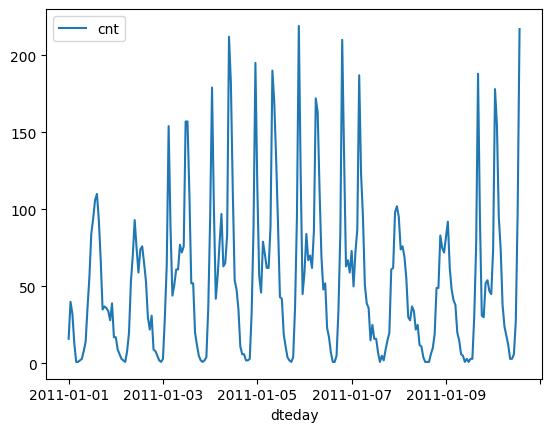

In [3]:
df[:24*10].plot(x='dteday', y='cnt')

Hay algunas variables categóricas: **season**, **weathersit**, **mnth**, **hr**, **weekday**. Necesitamos crear variables dummy para éstas. 

Así mismo, eliminaremos algunas variables que redundan o no aportan para el modelamiento el modelamiento: **instant**, **dteday**, **atemp**, **workingday**,**registered**, **casual** así como las **columnas originales de las variables que convertimos en dummies** si es necesario.

In [4]:
# TO_DO1 Crear las variables dummies indicadas, y eliminar los atributos indicados
df = pd.get_dummies(df, 
                    columns = ['season', 'weathersit', 'mnth', 'hr', 'weekday'])

In [5]:
X = df.drop(['instant', 'atemp', 'workingday', 'registered', 'casual'], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 58 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   dteday        17379 non-null  object 
 1   yr            17379 non-null  int64  
 2   holiday       17379 non-null  int64  
 3   temp          17379 non-null  float64
 4   hum           17379 non-null  float64
 5   windspeed     17379 non-null  float64
 6   cnt           17379 non-null  int64  
 7   season_1      17379 non-null  uint8  
 8   season_2      17379 non-null  uint8  
 9   season_3      17379 non-null  uint8  
 10  season_4      17379 non-null  uint8  
 11  weathersit_1  17379 non-null  uint8  
 12  weathersit_2  17379 non-null  uint8  
 13  weathersit_3  17379 non-null  uint8  
 14  weathersit_4  17379 non-null  uint8  
 15  mnth_1        17379 non-null  uint8  
 16  mnth_2        17379 non-null  uint8  
 17  mnth_3        17379 non-null  uint8  
 18  mnth_4        17379 non-nu

#### Cambiar la escala en variables cuantitativas (normalizar).
Para que el entrenamiento sea más fácil, estandarizaremos los datos de las variables contínuas, de manera que tengan media 0 y desviación estandar 1. 

Para esto, en las columnas de variables contínuas usamos la media y desviación estandar de la respectiva columna

$$col:=\frac{col-mean}{standardeviation}$$ 

In [6]:
from sklearn import preprocessing

In [7]:
# TO_DO 2 Estandarizar las columnas cuantitativas: cnt, temp, hum, windspeed.
scaler1 = preprocessing.MinMaxScaler()
scaler2 = preprocessing.MinMaxScaler()


scaled1 = scaler1.fit_transform(X[['cnt']])
scaled2 = scaler2.fit_transform(X[['temp', 'hum', 'windspeed']])


X[['cnt']] = pd.DataFrame(scaled1)
X[['temp', 'hum', 'windspeed']] = pd.DataFrame(scaled2)
X

,dteday,yr,holiday,temp,hum,windspeed,cnt,season_1,season_2,season_3,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2011-01-01,0,0,0.224490,0.81,0.000000,0.015369,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2011-01-01,0,0,0.204082,0.80,0.000000,0.039959,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2011-01-01,0,0,0.204082,0.80,0.000000,0.031762,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2011-01-01,0,0,0.224490,0.75,0.000000,0.012295,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2011-01-01,0,0,0.224490,0.75,0.000000,0.000000,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31,1,0,0.244898,0.60,0.193018,0.120902,1,0,0,...,0,0,0,0,1,0,0,0,0,0
17375,2012-12-31,1,0,0.244898,0.60,0.193018,0.090164,1,0,0,...,0,0,0,0,1,0,0,0,0,0
17376,2012-12-31,1,0,0.244898,0.60,0.193018,0.091189,1,0,0,...,1,0,0,0,1,0,0,0,0,0
17377,2012-12-31,1,0,0.244898,0.56,0.157870,0.061475,1,0,0,...,0,1,0,0,1,0,0,0,0,0


#### Crear conjuntos de entrenamiento, validación y test

En esta ocasión seleccionaremos los conjuntos de entrenamiento, vlaidación y test de forma ordenada. Para el test, seleccionaer los datos de aproximadamente los últimos 21 días. Para el conjunto de validación, tomar los datos de aproximadamente los últimos 60 días de los datos restantes.

In [8]:
# TO_DO3 Definir los conjuntos de train, test y validation.
# Darles los nombres train, val, test.
days_and_indexes = X.groupby(by = 'dteday').groups
days = list(days_and_indexes.keys())

#botamos la columna después de usarla vilmente
X = X.drop(['dteday'], axis=1)


def days_partition(init, end):

    """
        init: fecha de inicio del día
        end: fecha de final del día
    """

    #lista de los indices del dataframe que 
    #corresponden a las mediciones de los días
    all_datapoints = []

    #para cada día en los días seleccionados por 
    #el intervalo init, end
    for d in days[init:end]:

        #tome los indices de las mediciones asociadas
        #a ese día y agregelo a la lista
        for d2 in days_and_indexes[d]:
            all_datapoints.append(d2)

    return X.iloc[all_datapoints]

test = days_partition(-21,-1)
validation = days_partition(-60,-21)

train = days_partition(0, -60)

In [9]:
print(f"test: {len(test)}")
print(f"validation: {len(validation)}")
print(f"train: {len(train)}")

test: 478
validation: 934
train: 15943


#### Convertir los datos a tensores y prepararlos para alimentar la red
A continuación  crearemos una clase (*MyDataset*) que nos prepara los datos para alimentar la red neuronal, convirtiendolos a parejas ordenadas de tensores conteniento los atributos y la variable objetivo. Sus parámetros son: el dataset df y el nombre de la columna objetivo en el dataset.


In [10]:
class MyDataset():
 
  def __init__(self,df,target_column):
    #price_df = pd.read_csv(file_name)
 
    # x = price_df.iloc[:,0:8].values
    # y = price_df.iloc[:,8].values
    # y_train = df_train['activity']
    # X_train = 

    y      = df[target_column].values
    X      = df.drop(target_column,axis=1).values
    self.X = torch.tensor(X, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.float32)
 
  def __len__(self):
    return len(self.y)
   
  def __getitem__(self,idx):
    return self.X[idx],self.y[idx]

Ahora usamos los Dataloaders para los conjuntos set, val y test.

In [11]:
# Usar la clase MyDataset para preparar cada conjunto en forma de tensores
train_sec=MyDataset(train,'cnt')
test_sec=MyDataset(test,'cnt')
val_sec=MyDataset(validation,'cnt')

In [12]:
# Definir los DataLoaders para cargar la información pro lotes
train_data=DataLoader(
    train_sec,
    batch_size=1,
    shuffle=False,
    #num_workers=0,
    #collate_fn=None,
    #pin_memory=False,
 )

test_data=DataLoader(
    test_sec,
    batch_size=3,
    shuffle=False,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

val_data=DataLoader(
    val_sec,
    batch_size=3,
    shuffle=False,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

Vamos a imprimir el primer bath del Test Set para visualizar y entender, sus tamaños y cómo el Dataloader ingresan los datos a la red neuronal.

In [13]:
for i, (data, labels) in enumerate(test_data):
  print(data.shape, labels.shape)
  print(data,labels)
  break;

torch.Size([3, 56]) torch.Size([3])
tensor([[1.0000, 0.0000, 0.4490, 0.7700, 0.5439, 0.0000, 0.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [1.0000, 0.0000, 0.4082, 0.7100, 0.5264, 0.0000, 0.0000, 0.0000, 1.0000,
         1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000

### Definir la classe Net con la estructura de la red neuronal

Basándose en el taller pasado, construya una red neuronal que tenga las siguientes características: 
- Una sola capa oculta. Usted decida el número de nodos. (Puede hacer entrenamientos pequeños, con una sola epoch por ejemplo, para hacer pruebas y decidir un buen número de nodos. Entre más nodos aprenderá más características de los datos, pero tardará más. Busque un buen equilibrio).
- Una función de activación signoide para la capa oculta.







In [14]:
# TO_DO 4 Escribir el código para la arquitectura de la red neuonal.
class NeuralNetwork(nn.Module):
    def __init__(self,  nhidden, input_sz=56, output_sz=1):
        super().__init__()
        self.flatten = nn.Flatten()
        self.part1 = nn.Sequential(
            nn.Linear(input_sz, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, output_sz),)

    def forward(self, x):
        x = self.flatten(x)
        logits = self.part1(x)
        return logits


Revisamos que estemos usando GPU y definimos el dispositivo 

In [15]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? False


In [16]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cpu


Definimos el modelo, el optimizadoy y la función de costo.

In [17]:
model = NeuralNetwork(nhidden = 30)

#TO_DO 5 Definir el optimizador Stochastic gradient descent y la función
# MeanSquareError. Usar Learnig rate de 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
optimizer.zero_grad()

#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

### Entrenando la red y guardando el mejor modelo

A continuación definimos la función de entrenamiento.

In [18]:
#pasamos el modelo al dispositivo GPU
model.to(device)
def train_model(model,
                optimizer,
                loss_module,
                train_loader,
                valid_loader, 
                num_epochs):
  
  #Vamos a encontrar el menor valor de error de validación.
  #Por eso la inicializmaos como 'infinito'
  valid_loss_min =np.inf  
  
  for i in range(num_epochs):
      
    #ponemos el modelo en modo entrenamiento.
    #Es importante en otras arquitecturas como redes convolucionales.
    model.train()  
    train_loss = 0.0
    v_loss = 0.0

    # TODO 6 Completar el código a continuación
    for data, target in train_loader:
        # mover los tensores de atributos y etiquetas al dispositivo GPU
        inputs, labels = data.to(device), target.to(device)
        
        # Reiniciar los gradientes
        optimizer.zero_grad()

        # forward pass: calcular la salida para los datos de entrada..
        outputs = model(inputs)

        # calculate the batch loss
        loss = loss_module(outputs, labels)

        # backpropagation: cálculo de gradientes
        loss.backward()

        # actualizar los parámetros
        optimizer.step()


        # actualizar la cuenta de costos a lo largo de los lotes
        train_loss += loss.item()*data.size(0)
    # for data,labels in testloader:

    train_loss = train_loss/len(train_loader.dataset) 

    model.eval() #Ponemos el modelo en modo evaluación.

    #for param in model.parameters():
    #  print(param.data)
    # vamos a evaluar el modelo entrenado, calculando predicciones con el conjunto de validación
    for data,target in valid_loader:
      data=data.to(device)
      target=target.to(device)
      output=model(data)
      valid_loss= loss_module(output, target)
      valid_loss += loss.item()*data.size(0)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    #imprimir estadísticas de entrenamiento y validación
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        i, train_loss, valid_loss))
    

    #Guardamos el modelo con el menor error de validación.
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_bikeshare.pt')
        valid_loss_min = valid_loss

    return valid_loss, train_loss


Ahora entrene el modelo. Intente primero con una sola epoch para verificar que el codigo esté correcto. Luego de eso prube con más epochs. Con un buen rato de tiempo disponible podría intentar 100, 500, las que más quiera intentar de acuerdo a como vea su desempeño.

In [19]:
valid_loss_min =np.inf  
best = 0

for size in range(10, 100, 10):
    model = NeuralNetwork(nhidden = size)
    optimizer.zero_grad()

    valid_loss, train_loss = train_model(model,
                                         optimizer,
                                         criterion,
                                         train_data,
                                         val_data, 4)  

    if valid_loss < valid_loss_min:
        valid_loss_min = valid_loss
        best = size

print(f"best performance got with n {best} and validation loss {valid_loss_min}")
    


/shared-libs/python3.9/py/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/shared-libs/python3.9/py/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch: 0 	Training Loss: 0.246484 	Validation Loss: 0.000198
Validation loss decreased (inf --> 0.000198).  Saving model ...
Epoch: 0 	Training Loss: 0.073216 	Validation Loss: 0.000012
Validation loss decreased (inf --> 0.000012).  Saving model ...
Epoch: 0 	Training Loss: 0.059217 	V

In [20]:
#completar
model = NeuralNetwork(nhidden = 60)
optimizer.zero_grad()

train_model(model, optimizer, criterion, train_data, val_data, 10)  

Epoch: 0 	Training Loss: 0.045861 	Validation Loss: 0.000001
Validation loss decreased (inf --> 0.000001).  Saving model ...


(tensor(1.2266e-06, grad_fn=<DivBackward0>), 0.04586071455627264)

Cargamos el mejor modelo obtenido del entrenamiento. 
*Observación:* En el entrenamiento se guarda un modelo en un archivo .pt usted puede descargar el archivo y guardarlo localmente. De esta forma, si quiere usar el modelo nuevamente sin volver a realizar entrenamiento, sólo carguelo como se indica en la siguiente celda.

In [21]:
model.load_state_dict(torch.load('model_bikeshare.pt'))

<All keys matched successfully>

Visualizamos los parámetros del modelo obtenido anteriormente

In [22]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data)

part1.0.weight tensor([[ 0.0239,  0.1320,  0.0354,  ..., -0.0760, -0.0436,  0.0580],
        [-0.0604, -0.0331, -0.0978,  ..., -0.0681,  0.0608, -0.1308],
        [ 0.1318,  0.1091,  0.0506,  ..., -0.0777, -0.1093,  0.0590],
        ...,
        [ 0.1142, -0.0919, -0.0561,  ...,  0.1207,  0.0390,  0.0034],
        [-0.0384,  0.0179, -0.0944,  ..., -0.1180, -0.0705,  0.0389],
        [ 0.0197, -0.1018,  0.0621,  ...,  0.0694,  0.0101, -0.0302]])
part1.0.bias tensor([-0.0068,  0.0131,  0.0012, -0.0224,  0.1103, -0.1274, -0.0566, -0.0051,
        -0.0162, -0.1243,  0.1261,  0.1329,  0.0786, -0.0695, -0.0263, -0.0352,
         0.0280, -0.0238, -0.0292,  0.1225, -0.0877,  0.0766,  0.1226,  0.0572,
        -0.0265,  0.0494,  0.0067,  0.0385,  0.0272, -0.0075, -0.0209,  0.0700,
         0.0600, -0.1072, -0.0245, -0.1250, -0.0120,  0.0794,  0.0721, -0.0080,
        -0.0059,  0.0875, -0.0679,  0.0738, -0.1260,  0.0599,  0.0144, -0.1286,
        -0.0016,  0.0046,  0.0733, -0.0742,  0.1167,  0.08

### Evaluación del modelo
Ahora la prueba final con el test set. 

In [23]:
test_loss = 0.0
criterion = nn.MSELoss()

for data, target in test_data:
  data   = data.to(device)
  target = target.to(device)
  output = model(data)
  loss   = criterion(output,target)
  test_loss += loss.item()*data.size(0)

test_loss = test_loss/len(test_data.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))


Test Loss: 0.026610



### Usando el modelo en contexto

TO_DO 7: Finalmente, utilice el modelo encontrado para predecir el número de bicicletas rentadas en tres momentos (fecha, hora y demás atributos) diferentes que usted elija (pueden ser tomados del test set o con unos atributos nuevos que usted elija). 
Comente por favor lo siguiente: 
- Escribr si son atributos que usted seleccionó del dataset o unos nuevos ***Si son los mismos atributos***.
- Describa cómo obtuvo el valor de la predicción y qué valor dió (tenga en cuenta que la salida está normalizada, pero queremos la cantidad de bicicletas) ***Primero obtuvimos el siguiente batch y lo metimos al modelo para predecir adecuadamente la salida, dado que las entradas estaban escaladas con el MinMaxScaler, lo utilizamos con su inversa para calcular la correspondiente cantidad de bicis.***
- Si son atributos seleccionados del test set, compare su resultado con la etiqueta original. ¿Qué tal se desempeñó en esos tres casos? 

In [46]:
data, target = next(iter(test_data))
inputs, labels = data.to(device), target.to(device)

# forward pass: calcular la salida para los datos de entrada..
outputs = model(inputs)
outputs

tensor([[0.1298],
        [0.1400],
        [0.1025]], grad_fn=<AddmmBackward0>)

In [47]:
print("Cantidad de bicis que se prestan originalmente: ")
orig = scaler1.inverse_transform(labels.reshape(-1, 1))
orig

Cantidad de bicis que se prestan originalmente: 


array([[31.0000006 ],
       [ 7.99999984],
       [ 1.        ]])

In [48]:
print("Cantidad de bicis que se prestan según la predicción del modelo: ")
pred = scaler1.inverse_transform(outputs.detach().numpy())
pred

Cantidad de bicis que se prestan según la predicción del modelo: 


array([[127.695114],
       [137.59758 ],
       [100.99408 ]], dtype=float32)

Como vemos lo hace terrible...

In [52]:
from sklearn.metrics import mean_squared_error as msejiji

msejiji(orig, pred)

12048.09790280868

Ahora vamos a verlo para todo el dataset, spoiler, no es que le vaya mejor que antes ...

In [70]:
preds = model(test_data.batch_sampler.sampler.data_source.X)
preds = scaler1.inverse_transform(preds.detach().numpy())

origs = test_data.batch_sampler.sampler.data_source.y
origs = scaler1.inverse_transform(origs.reshape(-1,1))

msejiji(origs, preds)

24937.38670627432

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6bfcf351-25b4-498b-af75-310729c1a691' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>